In [ ]:
from langchain_ollama import ChatOllama
from ddgs import DDGS
import time  
from langchain_core.tools import tool, Tool
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.prompts import PromptTemplate 
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, List, Annotated, Literal
from langchain_core.prompts import MessagesPlaceholder
from langchain_core.prompts import ChatPromptTemplate

In [2]:
#llm  = ChatOllama(model="deepseek-r1:8b")
#llm  = ChatOllama(model="llama3.2:3b")
#llm  = ChatOllama(model="llama3.1:8b")
#llm  = ChatOllama(model="qwen3:8b")
#llm  = ChatOllama(model="qwen3:4b")
llm  = ChatOllama(model="qwen3:8b")

In [3]:
class AgentState(TypedDict):
    question: str               # User question (immutable)
    draft: str                  # Initial response draft
    critique: Annotated[str, "After reflection"]  # Self-critique of draft
    refined: Annotated[str, "After refinement"]   # Final refined answer
    iterations: Annotated[int, "Refinement count"] # Track improvement cycles
    status: Literal["draft", "critique", "refined", "final"]  # Workflow stage

In [4]:
@tool
def ddg_search(query: str) -> str:
    """Search DuckDuckGo for current information. Input: search query string"""
    try:
        # Retry logic to handle transient issues, know issue
        results = None
        RETRY_COUNT = 5
        for i in range(RETRY_COUNT):
            with DDGS() as ddgs:
                results = ddgs.text(query, max_results=3)
            
            if results is not None and len(results) > 0:
                break
            time.sleep(1)

        if not results:
            return "No search results found"
            
        formatted_results = []
        for i, result in enumerate(results, 1):
            formatted_results.append(
                f"{i}. {result.get('title', 'No title')}\n"
                f"   {result.get('body', 'No description')}\n"
                f"   URL: {result.get('href', 'No URL')}"
            )
        
        return "\n\n".join(formatted_results)
    except Exception as e:
        return f"Search error: {str(e)}"


In [5]:
DRAFT_PROMPT = ChatPromptTemplate.from_template("""You're an AI assistant. Answer the question clearly and concisely.
<question>
{question}
</question>
Response:"""
)

In [ ]:
CRITIQUE_PROMPT = ChatPromptTemplate.from_template(
    """Critique this response to the question. Identify 3 flaws: factual inaccuracies, 
lack of clarity, missing information, or poor structure. Be specific.

<question>
{question}
</question>

<draft_response>
{draft}
</draft_response>

Critique:""", MessagesPlaceholder(variable_name="agent_scratchpad")
)

In [ ]:
REFINE_PROMPT = ChatPromptTemplate.from_template(
    """Improve this response based on the critique. Maintain original style. 
Address all critique points.

<question>
{question}
</question>

<critique>
{critique}
</critique>

<original_response>
{draft}
</original_response>

Improved Response:""", MessagesPlaceholder(variable_name="agent_scratchpad")
)

In [8]:
def generate_initial_draft(state: AgentState):
    """Node: Create initial response draft"""
    chain = DRAFT_PROMPT | llm
    response = chain.invoke({"question": state["question"]})
    return {
        "draft": response.content,
        "iterations": 0,
        "status": "draft"
    }

In [9]:
def reflect_on_draft(state: AgentState):
    """Node: Generate critique of initial draft"""
    chain = CRITIQUE_PROMPT | llm
    response = chain.invoke({
        "question": state["question"],
        "draft": state["draft"]
    })
    return {
        "critique": response.content,
        "status": "critique"
    }

In [10]:
def refine_response(state: AgentState):
    """Node: Improve draft based on critique"""
    chain = REFINE_PROMPT | llm
    response = chain.invoke({
        "question": state["question"],
        "draft": state["draft"],
        "critique": state["critique"]
    })
    return {
        "refined": response.content,
        "iterations": state["iterations"] + 1,
        "status": "refined"
    }


In [11]:
def quality_validator(state: AgentState):
    """Decision node: Determine if refinement is needed"""
    # Simple iteration-based stopping condition
    if state["iterations"] >= 2:  # Max 2 refinement cycles
        return "final"
    
    # Content-based validation (simplified)
    critique = state["critique"].lower()
    if any(term in critique for term in ["excellent", "perfect", "no issues"]):
        return "final"
    return "needs_refinement"

In [12]:
workflow = StateGraph(AgentState)
 
workflow.add_node("draft", generate_initial_draft)
workflow.add_node("critique", reflect_on_draft)
workflow.add_node("refine", refine_response)

workflow.add_edge(START, "draft")
workflow.add_edge("draft", "critique")
workflow.add_edge("critique", "refine")

workflow.add_conditional_edges(
    "refine",
    quality_validator,
    {
        "final": END,
        "needs_refinement": "critique"  # Loop back for re-critique
    }
)

agent = workflow.compile()

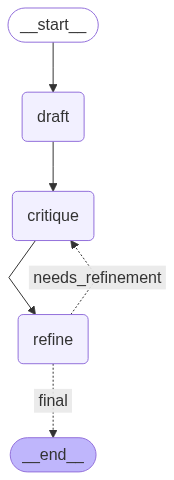

In [13]:
agent

In [14]:
def run_agent(question: str):
    """Execute the reflection agent"""
    result = agent.invoke({
        "question": question,
        "draft": "",
        "critique": "",
        "refined": "",
        "iterations": 0,
        "status": "draft"
    })
    return result

In [ ]:
QUESTION = "Explain quantum entanglement in simple terms"
    
# Run the agent
final_state = run_agent(QUESTION)

# Display results
print("\n===== FINAL OUTPUT =====")
print(f"Refined Answer ({final_state['iterations']} refinements):")
print(final_state["refined"])

print("\n===== DEBUG INFO =====")
print(f"Initial Draft:\n{final_state['draft']}\n")
print(f"Critique:\n{final_state['critique']}")

## **QWEN-3:8b**


## **QWEN-3:4b**


## **LLAMA-3.1:8b**
